# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [94]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

plt.style.use('seaborn')

C:\Users\пользователь\AppData\Local\Temp\ipykernel_6196\1282978369.py:12: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



Итак, прочитаем нашу таблицу:

In [95]:
churn_data = pd.read_csv('data/churn.zip')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

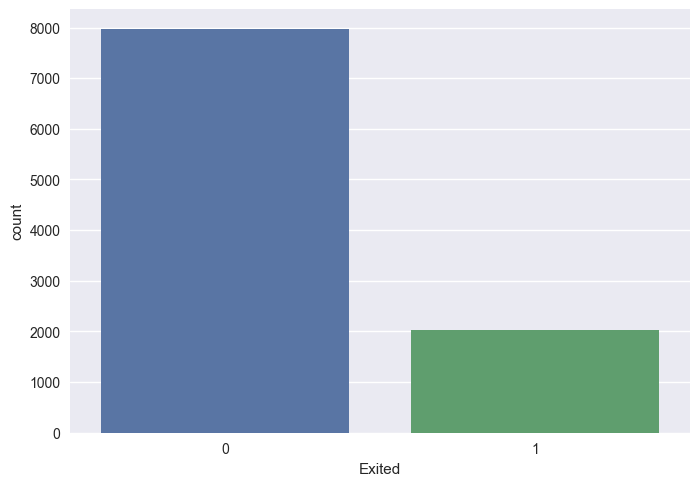

In [96]:
#сбалансированность классов
sns.countplot(data=churn_data, x='Exited');
#ушедших значительно меньше

In [97]:
types = churn_data.dtypes
num_features = list(types[(types != 'object')].index)
#убираем из него 'RowNumber','CustomerId'
num_features.remove('RowNumber')
num_features.remove('CustomerId')

#создаем список числовых признаков с большим количеством значений
num_features_cleared = []

for i in num_features:
    if len(churn_data[i].unique())>=5:
        num_features_cleared.append(i)

num_features_cleared

['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

In [98]:
#визуализируем зависимости для числовых небинарных признаков

import plotly.express as px
box_data = churn_data.copy()
box_data['Exited'] = box_data['Exited'].apply(lambda x: 'Ушедший клиент' if x==1 else 'Лояльный клиент') #преобразуем значения в столбце признак клиента


for i in num_features_cleared:
    box_data_temp = box_data.loc[::, ['Exited', i]] #создаем df для коробочной диаграммы, оставляя только нужные столбцы
    fig_box = px.box(
        data_frame=box_data_temp,
        x=i,
        color='Exited',
        labels={'Exited': 'Признак клиента'}
    )

    fig_box.update_xaxes(title_text=i, col=1, row=1) # добавляем подписи на оси 

    fig_box.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True) #добавляем рамки
    fig_box.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

    fig_box.show()
    
# У ушедших в среднем:
# ниже кредитный рейтинг, 
# выше средний возраст, 
# больше доля тех, кто пользуется услугами банка меньше 3 лет и больше 7 лет,
# больше сумма средств на счету
# сопоставимый уровень заработной платы

In [99]:
# смотрим числовые признаки с небольшим количеством значений
#создаем список числовых признаков с небольшим количеством значений
num_features_cleared_small = []

for i in num_features:
    if len(churn_data[i].unique())<=5:
        num_features_cleared_small.append(i)

num_features_cleared_small.remove('Exited')
num_features_cleared_small

['NumOfProducts', 'HasCrCard', 'IsActiveMember']

In [100]:
# визуализируем числовые признаки с небольшим количеством значений
def hist(column):
    hist_data= box_data.sort_values(by=column, ascending=True) # сортируем в порядке возрастания для корретного отображения в дальнейшем на оси абсцисс
    
    fig_hist = px.histogram(
        data_frame=hist_data,
        x=column,
        color='Exited',
        labels={'Exited': 'Признак клиента'},
        histnorm='percent' 
    )

    fig_hist.update_xaxes(title_text=column, col=1, row=1) # добавляем подписи на оси 
    fig_hist.update_yaxes(title_text='Количество клиентов', col=1, row=1)


    fig_hist.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True) #добавляем рамки
    fig_hist.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

    fig_hist.update_layout(bargap=0.2) #отступы между столбцами

    fig_hist.show()

for i in num_features_cleared_small:
    hist(i)
    
# У ушедших клиентов:
# почти нет тех, кто пользуется больше, чем 2мя продуктами
# сопоставимая доля тех у кого есть кредитная карта
# меньше доля со статусом "активный клиент"

In [101]:
# катагориальные признаки
cat_features = list(types[(types == 'object')].index)
#убираем фамилию
cat_features.remove('Surname')
cat_features

['Geography', 'Gender']

In [102]:
#визуализируем
for i in cat_features:
    hist(i)
    
# Больше всего ушедших клиентов из Германии и Франции
# Среди ушедших клиентов больше женщин

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [103]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [104]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [105]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [106]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [107]:
# Ваш код здесь
#создание трёх признаков
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

#перекодирование оставшихся текстовых признаков в числовые бинарные столбцы
#здесь остался один текстовый признак - пол, у которого два значения, поэтому оставим только один столбец
churn_data = pd.get_dummies(churn_data, drop_first=True)

#вывод статистических характеристик
display(churn_data.describe())


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487,0.524512
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558,0.499498
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676,0.000000
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275,0.000000
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143,1.000000
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941,1.000000
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889,1.000000


In [108]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2509 entries, 7 to 9998
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CreditScore          2509 non-null   int64  
 1   Age                  2509 non-null   int64  
 2   Tenure               2509 non-null   int64  
 3   Balance              2509 non-null   float64
 4   NumOfProducts        2509 non-null   int64  
 5   HasCrCard            2509 non-null   int64  
 6   IsActiveMember       2509 non-null   int64  
 7   EstimatedSalary      2509 non-null   float64
 8   Exited               2509 non-null   int64  
 9   BalanceSalaryRatio   2509 non-null   float64
 10  TenureByAge          2509 non-null   float64
 11  CreditScoreGivenAge  2509 non-null   float64
 12  Gender_Male          2509 non-null   uint8  
dtypes: float64(5), int64(7), uint8(1)
memory usage: 257.3 KB


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [109]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [110]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [111]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [112]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [113]:
# Ваш код здесь
#посмотрим на долю выбросов в данных
#объявим функцию
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

outliers_dict= {}
outliers_dict['features'] = X_train.columns
outliers_dict['count'] = []

for i in X_train.columns:
    
    outliers, cleaned = outliers_z_score(X_train, i, log_scale=False)
    outliers_dict['count'].append(outliers.shape[0])

outliers_df = pd.DataFrame(outliers_dict)

#display(outliers_df) 
# количество выбросов небольшое - максимум 26 шт., по одному признаку

#на всякий случай используем RobustScaler, чтобы уменьшить их влияения

scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


> Укажите название метрики и обоснования своего выбора здесь
Используем F-меру, т.к. она учитывает оба указанных фактора (минимизация ложноположительных и ложноотрицательных срабатываний). Более подробное обоснование -  в блоке ниже.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

> Ваши рассуждения и ответ — *здесь*.
> Чтобы минимизировать ложнопложительные срабатывания можно использовать метрику precision, чтобы минимизировать ложноотрицательные срабатывания - метрику recall. Так в задаче не указано, что всё таки важнее из двух: минимизировать ложноположительные или ложноотрицательные срабатывания, то лучше использовать F-меру, т.к. она учитывает влияние и метрики precision и метрики recall, т.к. является средним гармоническим между ними

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [114]:
# Ваш код здесь
#дополнительное задание
#пробуем поуправлять параметрами penalty и C, при формировании модели
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)


#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))
# значение F-меры на тестовой выборке - 0,50, модель следует считать недоообученой


              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.43      0.51       610

    accuracy                           0.73      1881
   macro avg       0.70      0.66      0.66      1881
weighted avg       0.72      0.73      0.72      1881

              precision    recall  f1-score   support

           0       0.76      0.87      0.81       424
           1       0.60      0.42      0.50       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.65       628
weighted avg       0.71      0.72      0.71       628



Max value F1-score - 0.494 with l1-regularization. C-value - 0.51
Max value F1-score - 0.497 with l2-regularization. C-value - 0.24


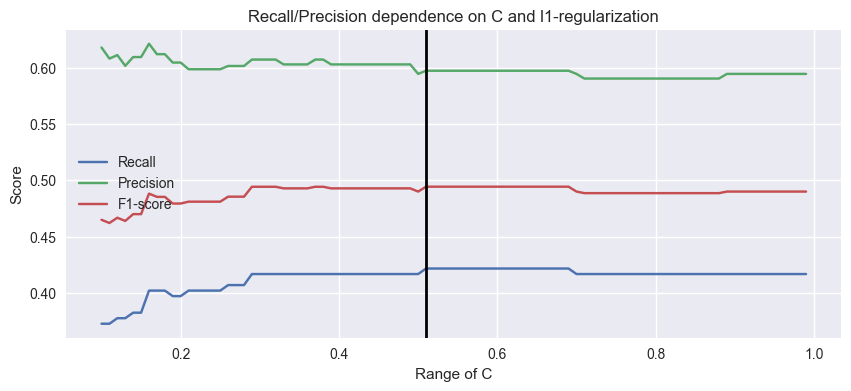

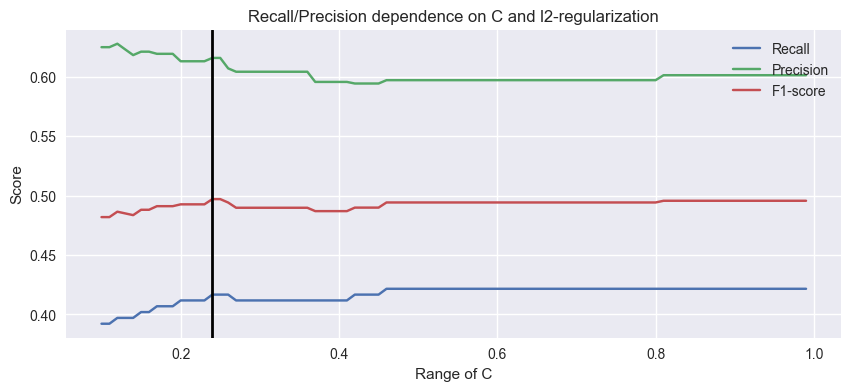

In [115]:
#дополнительное задание
#пробуем поуправлять параметрами penalty и C, при формировании модели
# напишем функцию с изменяемыми параметрами

def logreg_with_penalties (penalty_type):
    recall_scores = []
    precision_scores = []
    f1_scores = []

    #Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
    thresholds = np.arange(0.1, 1, 0.01)

    for threshold in thresholds:
        #Создаем объект класса логистическая регрессия
        log_reg = linear_model.LogisticRegression(
        penalty=penalty_type,
        C=threshold,
        random_state=42, #генератор случайных чисел
        max_iter=1000, #количество итераций на сходимость
        solver='liblinear' #добавил liblinear, т.к. l1-регуляризация не работает со стандартным алгоритмом lbfgs
        )
        #Обучаем модель, минимизируя logloss
        log_reg.fit(X_train_scaled, y_train)

        #Делаем предсказание для тренировочной выборки
        y_train_pred = log_reg.predict(X_train_scaled)
    
        #Делаем предсказание для тестовой выборки
        y_test_pred = log_reg.predict(X_test_scaled)
    
        recall_scores.append(metrics.recall_score(y_test, y_test_pred))
        precision_scores.append(metrics.precision_score(y_test, y_test_pred))
        f1_scores.append(metrics.f1_score(y_test, y_test_pred))
        
    #Визуализируем метрики при различных threshold
    fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
    #Строим линейный график зависимости recall от threshold
    ax.plot(thresholds, recall_scores, label='Recall')
    #Строим линейный график зависимости precision от threshold
    ax.plot(thresholds, precision_scores, label='Precision')
    #Строим линейный график зависимости F1 от threshold
    ax.plot(thresholds, f1_scores, label='F1-score')
    
    #вертикаль максимального значения метрики
    ax.axvline(thresholds[f1_scores.index(max(f1_scores))], color='k', lw=2)
    
    #Даем графику название и подписи осям
    ax.set_title('Recall/Precision dependence on C and {}-regularization'.format(penalty_type))
    ax.set_xlabel('Range of C')
    ax.set_ylabel('Score')
    ax.legend();
    
    print('Max value F1-score - {} with {}-regularization. C-value - {}'.format(round(max(f1_scores), 3), penalty_type, round(thresholds[f1_scores.index(max(f1_scores))],3)))
    
    
logreg_with_penalties('l1')
logreg_with_penalties('l2')
# после увеличения С до 0,51 - метрики перестают улучшаться при l1-регуляризации
# после увеличения С до 0,24 - метрики перестают улучшаться при l2-регуляризации
# итоговое максимальное значение F-меры в различных вариантах - около 0,5

# Вывод
* Значение F-меры при первоначальном расчете на тестовой выборке - 0,50, модель следует считать недоообученой
* После увеличения С до 0,51 - метрики перестают улучшаться при l1-регуляризации
* После увеличения С до 0,24 - метрики перестают улучшаться при l2-регуляризации
* Итоговое максимальное значение F-меры в различных вариантах регуляризации- около 0,5

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [116]:
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_poly = poly.transform(X_test_scaled)

#Создаём объект класса LogisticRegression
lg_model_poly = linear_model.LogisticRegression(
    random_state=42 #генератор случайных чисел
)
#Обучаем модель
lg_model_poly.fit(X_train_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lg_model_poly.predict(X_train_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lg_model_poly.predict(X_test_poly)


#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_predict_poly))
print(metrics.classification_report(y_test, y_test_predict_poly))
# значение F-меры на тестовой выборке стало хуже - 0,40, модель следует считать недоообученой
# по остальным метрикам значения стали хуже

              precision    recall  f1-score   support

           0       0.69      0.51      0.58      1271
           1       0.33      0.51      0.40       610

    accuracy                           0.51      1881
   macro avg       0.51      0.51      0.49      1881
weighted avg       0.57      0.51      0.53      1881

              precision    recall  f1-score   support

           0       0.68      0.50      0.58       424
           1       0.33      0.51      0.40       204

    accuracy                           0.50       628
   macro avg       0.51      0.51      0.49       628
weighted avg       0.57      0.50      0.52       628



c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



# Вывод
* значение F-меры на тестовой выборке при генерации полиномиальных признаков стало хуже - 0,40, модель следует считать недоообученой
* значения по другим метрикам результаты стали хуже
* Результат модели не улучшен

Max value F1-score - 0.682 with l1-regularization. C-value - 0.15
Max value F1-score - 0.405 with l2-regularization. C-value - 0.1


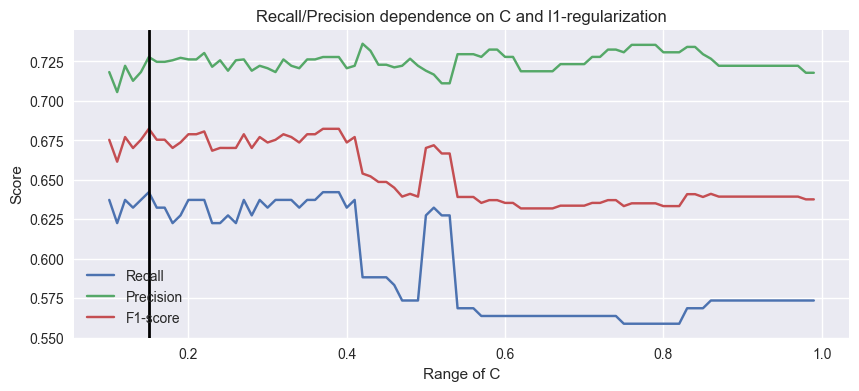

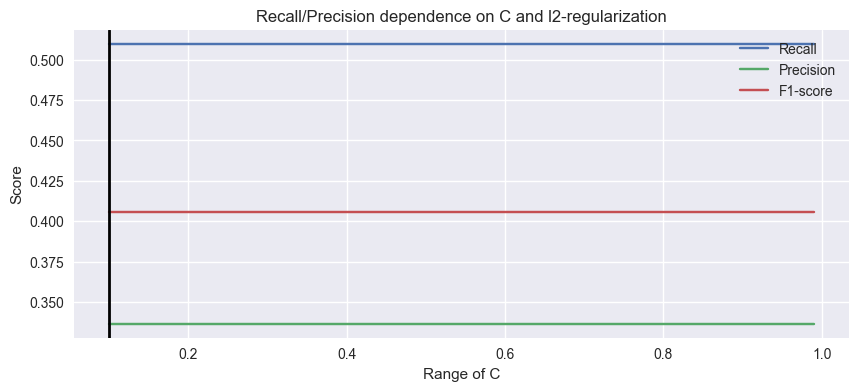

In [117]:
# дополнительное задание
# видоизменим нашу функцию с параметрами

def logreg_with_penalties_poly (penalty_type):
    recall_scores = []
    precision_scores = []
    f1_scores = []

    #Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
    thresholds = np.arange(0.1, 1, 0.01)

    for threshold in thresholds:
        #Создаем объект класса логистическая регрессия
        log_reg = linear_model.LogisticRegression(
        penalty=penalty_type,
        C=threshold,
        random_state=42, #генератор случайных чисел
        max_iter=1000, #количество итераций на сходимость
        solver='liblinear' #добавил liblinear, т.к. l1-регуляризация не работает со стандартным алгоритмом lbfgs
        )
        #Обучаем модель, минимизируя logloss
        log_reg.fit(X_train_poly, y_train)

        #Делаем предсказание для тренировочной выборки
        y_train_pred = log_reg.predict(X_train_poly)
    
        #Делаем предсказание для тестовой выборки
        y_test_pred = log_reg.predict(X_test_poly)
    
        recall_scores.append(metrics.recall_score(y_test, y_test_pred))
        precision_scores.append(metrics.precision_score(y_test, y_test_pred))
        f1_scores.append(metrics.f1_score(y_test, y_test_pred))
        
    #Визуализируем метрики при различных threshold
    fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
    #Строим линейный график зависимости recall от threshold
    ax.plot(thresholds, recall_scores, label='Recall')
    #Строим линейный график зависимости precision от threshold
    ax.plot(thresholds, precision_scores, label='Precision')
    #Строим линейный график зависимости F1 от threshold
    ax.plot(thresholds, f1_scores, label='F1-score')
    
    #вертикаль максимального значения метрики
    ax.axvline(thresholds[f1_scores.index(max(f1_scores))], color='k', lw=2)
    
    #Даем графику название и подписи осям
    ax.set_title('Recall/Precision dependence on C and {}-regularization'.format(penalty_type))
    ax.set_xlabel('Range of C')
    ax.set_ylabel('Score')
    ax.legend();
    
    print('Max value F1-score - {} with {}-regularization. C-value - {}'.format(round(max(f1_scores), 3), penalty_type, round(thresholds[f1_scores.index(max(f1_scores))],3)))
    
logreg_with_penalties_poly('l1')
logreg_with_penalties_poly('l2')

# Вывод
* Значение F-меры при первоначальном расчете на тестовой выборке - 0,50, модель следует считать недоообученой
* После увеличения С до 0,15 - метрики перестают улучшаться при l1-регуляризации
* При l2-регуляризации метрики не изменились при любом коэффициенте С
* Итоговое максимальное значение F-меры - 0,682 - достигается при l1-регуляризации, коэффициенте С равном 0,15

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision is ill-defined

Max value F1-score - 0.49 with threshold - 0.45.


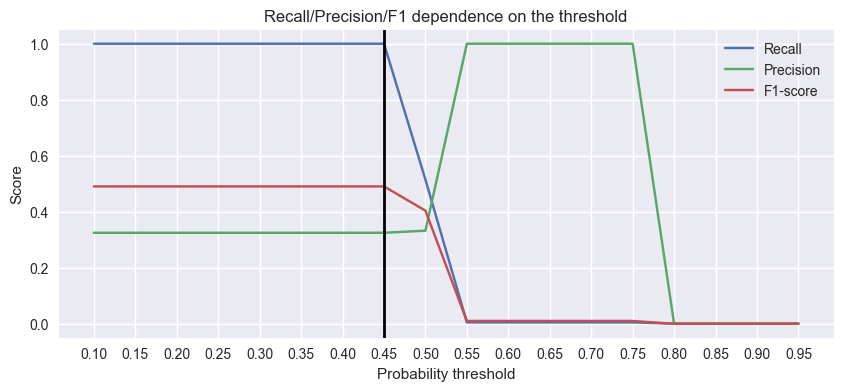

In [118]:
#используем шаблон кода

# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(lg_model_poly.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
recall_scores = []
precision_scores = []
f1_scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрики, ориентируемся на результат f1
    recall_scores.append(metrics.recall_score(y_test, y_test_pred_poly))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred_poly))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred_poly))
    
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')
#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
    
#вертикаль максимального значения метрики с наибольшим порогом f1
# ищем все вхождения max значения f1 меры
indices = [i for i in range(0, len(f1_scores)) if f1_scores[i]==max(f1_scores)]

# вставляем наибольшее значение
ax.axvline(thresholds[max(indices)], color='k', lw=2)

print('Max value F1-score - {} with threshold - {}.'.format(round(max(f1_scores), 3), round(thresholds[max(indices)], 3)))
    
#Даем графику название и подписи осям
ax.set_title('Recall/Precision/F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
ax.legend();

#Оптимальное значение порога - 0,45 на тестовой выборке

In [119]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.45
#Клиентов, для которых вероятность наличия ухода  > 0.45, относим к классу 1
#В противном случае — к классу 0
y_train_proba_pred = pd.Series(lg_model_poly.predict_proba(X_train_poly)[:, 1])

y_pred_opt_test = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
y_pred_opt_train = y_train_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)

#Считаем метрики на тренировочной и тестовой выборке
print(metrics.classification_report(y_train, y_pred_opt_train))
print(metrics.classification_report(y_test, y_pred_opt_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1271
           1       0.32      1.00      0.49       610

    accuracy                           0.32      1881
   macro avg       0.16      0.50      0.24      1881
weighted avg       0.11      0.32      0.16      1881

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       424
           1       0.32      1.00      0.49       204

    accuracy                           0.32       628
   macro avg       0.16      0.50      0.25       628
weighted avg       0.11      0.32      0.16       628



c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classifica

# Вывод
* Максимальное значение F1-меры - 0,49
* После порога в 0,45 значение метрики F1-меры ухудшается
* Если рассматривать первоначальнй вариант логистической регрессиии на полиномиальнах признаках (без учета допзадания с регуляризацией и влияния коэффициента С), то метрика F1-меры улучшилась - было 0,4, стало 0,49

## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [120]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [121]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [122]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.53


# Вывод
* Значение метрики F1-меры на тестовой выборке - 0,53, на тренировочной - 1,00.
* Т.к. максимальная глубина дерева была поставлена неограниченной, то модель полностью подстроилась под тренировочные данные и переобучилась. Это видно по самим метрикам: полное совпадение на тренировочной выборке и значение F1-меры в размере 0,53 на тестовой выборке

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [123]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    max_depth=8,
    criterion='entropy',
    min_samples_leaf=10,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.72
Test: 0.65


# Вывод
* Значение метрики F1-меры на тестовой выборке - 0,65, на тренировочной - 0,72.
* По сравнению с предыдущим результатом есть улучшение метрики на тестовой выборке, что связано связано с ограничением глубины дерева и минимального числа объектов на листе. Таким образом модель не полностью подстроилась под тренировочные данные.

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [124]:
from sklearn import ensemble #ансамбли

#Создаём объект класса RandomForest
rf_clf_full = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf=10, #минимальное число объектов на листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_full.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = rf_clf_full.predict(X_train)
y_pred_test = rf_clf_full.predict(X_test)
#Выводим отчёт о метриках
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.72
Test: 0.65


# Вывод
* Значение метрики F1-меры на тестовой выборке - 0,65, на тренировочной - 0,72.
* По сравнению с предыдущим результатом метрика не улучшилась либо улучшение незначительное, что вероятно связано с тем, что параметры ансамбля случайного леса и дерева решений из предыдущего задания совпадают.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

Max value F1-score - 0.689 with threshold - 0.35.


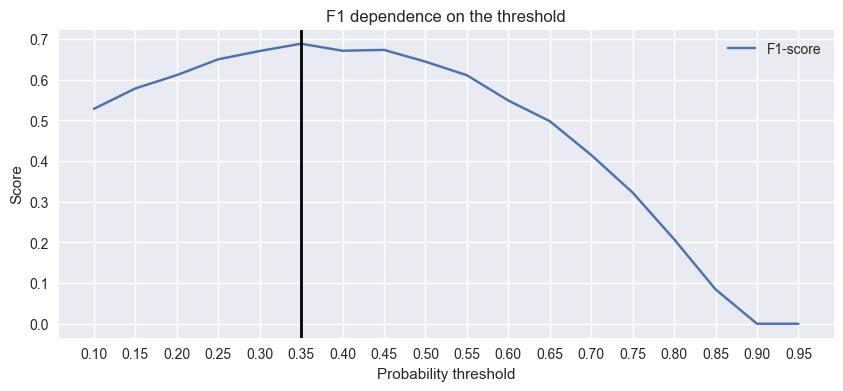

In [125]:
# ориентируемся на модель ансамбля случайного леса

# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred_rf = pd.Series(rf_clf_full.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_rf = y_test_proba_pred_rf.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_pred_rf)
    # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
    
    
#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores, label='F1-score')
    
#вертикаль максимального значения метрики с наибольшим порогом f1
# ищем все вхождения max значения f1 меры
indices = [i for i in range(0, len(scores)) if scores[i]==max(scores)]

# вставляем наибольшее значение
ax.axvline(thresholds[max(indices)], color='k', lw=2)

print('Max value F1-score - {} with threshold - {}.'.format(round(max(scores), 3), round(thresholds[max(indices)], 3)))
    
#Даем графику название и подписи осям
ax.set_title('F1 dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
#Устанавливаем отметки по оси x
ax.set_xticks(thresholds) 
ax.legend();
# оптимальное значение порога - 0,35

In [126]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.35
#Клиентов, для которых вероятность наличия ухода  > 0.35, относим к классу 1
#В противном случае — к классу 0
y_train_proba_pred_rf = pd.Series(rf_clf_full.predict_proba(X_train)[:, 1])

y_pred_opt_test_rf = y_test_proba_pred_rf.apply(lambda x: 1 if x > threshold_opt else 0)
y_pred_opt_train_rf = y_train_proba_pred_rf.apply(lambda x: 1 if x > threshold_opt else 0)

#Считаем метрики на тренировочной и тестовой выборке
print(metrics.classification_report(y_train, y_pred_opt_train_rf))
print(metrics.classification_report(y_test, y_pred_opt_test_rf))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      1271
           1       0.73      0.80      0.76       610

    accuracy                           0.84      1881
   macro avg       0.81      0.83      0.82      1881
weighted avg       0.84      0.84      0.84      1881

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       424
           1       0.63      0.76      0.69       204

    accuracy                           0.78       628
   macro avg       0.75      0.77      0.76       628
weighted avg       0.79      0.78      0.78       628



# Вывод
* Оптимальный порог вероятности для достижения максимального значения F1-меры - 0,35
* На оптимальном пороге вероятности значение F1-меры: на тренировочной выборе - 0,76, на тестовой - 0,69. 
* Указанные выше показатели - лучшие среди рассмотренных вариантов, связанных с деревьями решений.


За счет постепенного ввода ограничений для модели (глубина дерева решений, минимальное значение объектов на листе) удалось улучшить первоначальное значение F1-меры на тестовой выборке с 0,53 до 0,65. Использование случайного леса не помогло улучшить метрику, т.к. использовались те же параметры. За счет изменения порога вероятности удалось улучшить  значение F1-меры на тестовой выборке с 0,65 до 0,69. Пока это лучший результат.

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [127]:
churn_data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male
7,376,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517,0
15,616,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889,1
16,653,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621,1
26,756,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000,1
28,574,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837,0


In [128]:
#создадим словарь
vasiliy = {
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}

#создаем df на основе указанного словаря
df_vasiliy = pd.DataFrame(data = vasiliy)

#выполняем преобразования, которые делали с исходным df - churn

#создание трёх признаков
df_vasiliy['BalanceSalaryRatio'] = df_vasiliy['Balance'] / df_vasiliy['EstimatedSalary']
df_vasiliy['TenureByAge'] = df_vasiliy['Tenure'] / df_vasiliy['Age']
df_vasiliy['CreditScoreGivenAge'] = df_vasiliy['CreditScore'] / df_vasiliy['Age']

#перекодирование оставшихся текстовых признаков в числовые бинарные столбцы
#здесь остался один текстовый признак - пол, у которого два значения, поэтому оставим только один столбец
#столбец Gender удалим
df_vasiliy['Gender_Male'] = df_vasiliy['Gender'].apply(lambda x: 1 if x=='Male' else 0)
df_vasiliy = df_vasiliy.drop(['Gender'], axis = 1)

#масштабировать данные не будем, т.к. модель с лучшими результатами (ансамбль случайный лес) обучалась на обычных данных
#df_vasiliy_scaled = scaler.transform(df_vasiliy)

#Определяем вероятность для Василия
y_new_proba_pred_rf = rf_clf_full.predict_proba(df_vasiliy)
print('Predicted probability: {}%'.format(np.round(y_new_proba_pred_rf[0][1]*100, 2)))
# Вероятность, что Василий откажется от услуг банка - 62,24%


Predicted probability: 62.24%
